# 1. Downloading the Resume Corpus

In [1]:
!git clone https://github.com/florex/resume_corpus.git
!mv resume_corpus resume_corpus_repo
!mkdir corpus && unzip resume_corpus_repo/resumes_corpus.zip -d corpus
!pip install -q scikit-multilearn
!pip install -q transformers

Cloning into 'resume_corpus'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 50 (delta 16), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (50/50), done.
mv: cannot move 'resume_corpus' to 'resume_corpus_repo/resume_corpus': Directory not empty
mkdir: cannot create directory ‘corpus’: File exists


# 2. Importing libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import torch
import transformers

from datetime import datetime
from sklearn.metrics import hamming_loss, accuracy_score, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader

In [3]:
# Set random seed - being able to reproduce the experiment
SEED = 1

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 3. Reading the corpus

In [4]:
resume_text, resume_labels = {}, {}
for filename in os.listdir('corpus'):
  index = int(filename.replace('.lab', '').replace('.txt', '')) - 1
  with open('corpus/' + filename, encoding='latin1') as f:
    if filename.endswith('txt'):
      resume_text[index] = f.read()
    elif filename.endswith('lab'):
      resume_labels[index] = f.read().splitlines()

txt_series = pd.Series(resume_text, name='text')
lbl_series = pd.Series(resume_labels, name='labels')
df = pd.concat([txt_series, lbl_series], axis=1)

# 4. One-Hot Encoding

In [5]:
mlb = MultiLabelBinarizer()
one_hot_encoding = pd.DataFrame(mlb.fit_transform(df['labels']), index=df.index, columns=mlb.classes_)
df = pd.concat([df.drop('labels', 1), one_hot_encoding], axis=1)
df['labels'] = df[df.columns[1:]].values.tolist()
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,text,Database_Administrator,Front_End_Developer,Java_Developer,Network_Administrator,Project_manager,Python_Developer,Security_Analyst,Software_Developer,Systems_Administrator,Web_Developer,labels
0,"Database Administrator <span class=""hl"">Databa...",1,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"Database Administrator <span class=""hl"">Databa...",1,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Oracle Database Administrator Oracle <span cla...,1,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Amazon Redshift Administrator and ETL Develope...,1,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Scrum Master Scrum Master Scrum Master Richmon...,1,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# 5. Sampling

In [6]:
def check_dataframe():
  df_cp = df.drop(columns=['text', 'labels'])
  row_sum=df_cp.iloc[:,:].sum(axis=1)

  print("Total number of articles = ", len(df_cp))
  print("Total number of articles without label = ", row_sum[row_sum==0].count())
  print("Total labels = ", row_sum.sum())
  print("\nCount by label:")
  print(df_cp.iloc[:,:].sum())
  print('-------------------------------------------')

check_dataframe()
df = df.sample(n=20000, random_state=SEED)
check_dataframe()

df = df[['text', 'labels']]
df.head()

Total number of articles =  29783
Total number of articles without label =  748
Total labels =  52972

Count by label:
Database_Administrator     3299
Front_End_Developer        3977
Java_Developer             3252
Network_Administrator      4460
Project_manager            4550
Python_Developer           2836
Security_Analyst           3022
Software_Developer        15013
Systems_Administrator      5969
Web_Developer              6594
dtype: int64
-------------------------------------------
Total number of articles =  20000
Total number of articles without label =  513
Total labels =  35675

Count by label:
Database_Administrator     2191
Front_End_Developer        2691
Java_Developer             2224
Network_Administrator      2981
Project_manager            3035
Python_Developer           1922
Security_Analyst           2042
Software_Developer        10118
Systems_Administrator      4022
Web_Developer              4449
dtype: int64
-------------------------------------------


,text,labels
17832,Data Mining Project Data Mining Project Comput...,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]"
12361,"Sr. Java/J2EE developer Sr. <span class=""hl"">J...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1]"
9759,"Cyber Security Analyst Cyber <span class=""hl"">...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
23312,"Hadoop Developer Hadoop <span class=""hl"">Devel...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
11431,Security Automation Analyst (ITS2) <span class...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


# 6. Text Cleanup

In [7]:
def remove_html_tags(text):
  return re.sub("<.*?>", "", text)

def remove_irrelevant_symbols(text):
    text = re.sub("[^a-zA-Z0-9\.,;\?!-/\\\\]", " ", text) 
    return ' '.join(text.split())
 
df['text'] = df['text'].apply(remove_html_tags).apply(remove_irrelevant_symbols)
df.head()

,text,labels
17832,Data Mining Project Data Mining Project Comput...,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]"
12361,Sr. Java/J2EE developer Sr. Java/J2EE develope...,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 1]"
9759,Cyber Security Analyst Cyber Security Analyst ...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
23312,Hadoop Developer Hadoop Developer Hadoop Devel...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
11431,Security Automation Analyst (ITS2) Security Au...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


# 7. Definig Datasets and Configurations

In [8]:
TOKENS_MAX_LEN = 500
TRAIN_BATCH_SIZE = 16
DEFAULT_BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0001
TOKENIZER = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FINAL_MODEL_PATH = 'final_model.pth'

print(f"Using {DEVICE} device")

Using cuda device


In [9]:
class ResumeDataset(Dataset):
    def _tokenize(text):
        return TOKENIZER.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=TOKENS_MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True
        )

    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.tokens = [ResumeDataset._tokenize(txt) for txt in dataframe.text]

    def __len__(self):
        return len(self.dataframe.text) # number of documents

    def __getitem__(self, index):
        inputs = self.tokens[index]
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            'targets': torch.tensor(self.dataframe.labels[index], dtype=torch.float)
        }

In [10]:
train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=SEED)
train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.25, random_state=SEED)

training_set = ResumeDataset(train_dataset.reset_index(drop=True))
validation_set = ResumeDataset(validation_dataset.reset_index(drop=True))
testing_set = ResumeDataset(test_dataset.reset_index(drop=True))

print(f'{len(training_set)} documents for training dataset')
print(f'{len(validation_set)} documents for validation dataset')
print(f'{len(testing_set)} documents for testing dataset')

12000 documents for training dataset
4000 documents for validation dataset
4000 documents for testing dataset


# 8. Defining Loaders and Model

In [11]:
def seed_worker(worker_id):
    np.random.seed(SEED)
    random.seed(SEED)

g = torch.Generator()
g.manual_seed(SEED)

training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
validation_loader = DataLoader(validation_set, batch_size=DEFAULT_BATCH_SIZE, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
testing_loader = DataLoader(testing_set, batch_size=DEFAULT_BATCH_SIZE, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)

In [12]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 10)
    
    def forward(self, ids, mask, token_type_ids):
        _, bert_output = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids)
        droput_output = self.dropout(bert_output)
        return self.linear(droput_output)

model = Model()
model.to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      

# 9. Training the Model

In [13]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)
total_training_steps = len(training_loader)
train_losses = []

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

def train(epoch):
    model.train()
    total_loss, running_loss = 0.0, 0.0
    for step, data in enumerate(training_loader, 0):
        ids = data['ids'].to(DEVICE, dtype = torch.long)
        mask = data['mask'].to(DEVICE, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype = torch.long)
        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()

        targets = data['targets'].to(DEVICE, dtype = torch.float)
        loss = loss_fn(outputs, targets)

        loss_item = loss.item()        
        running_loss += loss_item
        total_loss += loss_item

        if step % 50 == 49:
            print(f'[{datetime.now()}] Epoch: {epoch}, Step: {step+1}/{total_training_steps}, Avg. Running Loss: {running_loss / 50:.3f}')
            running_loss = 0.0
        
        loss.backward()
        optimizer.step()
    train_losses.append(total_loss / total_training_steps)

In [14]:
eval_accuracies = []
eval_hamming_losses = []
min_validation_loss = np.inf

def evaluate(epoch):
    model.eval()
    targets=[]
    predictions=[]
    with torch.no_grad():
        for _, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(DEVICE, dtype = torch.long)
            mask = data['mask'].to(DEVICE, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(DEVICE, dtype = torch.long)
            batch_targets = data['targets'].to(DEVICE, dtype = torch.float)
            batch_predictions = model(ids, mask, token_type_ids)
            targets.extend(batch_targets.cpu().detach().numpy().tolist())
            predictions.extend(torch.sigmoid(batch_predictions).cpu().detach().numpy().tolist())
    predictions = np.array(predictions) >= 0.5
    
    accuracy = accuracy_score(targets, predictions)
    eval_accuracies.append(accuracy)
    h_loss = hamming_loss(targets, predictions)
    eval_hamming_losses.append(h_loss)

    print('----------------------------------------------------------------------')
    print(f'[{datetime.now()}] Epoch: {epoch}, Accuracy (Exact Match Ratio) Score={accuracy}')
    print(f'[{datetime.now()}] Epoch: {epoch}, Hamming Loss={h_loss}')
    print(f'[{datetime.now()}] Epoch: {epoch}, Classification Report:')
    print(classification_report(targets, predictions, digits=4, zero_division=0, target_names=mlb.classes_))

    global min_validation_loss
    if min_validation_loss > h_loss:
        print(f'Validation Loss Decreased({min_validation_loss:.6f}--->{h_loss:.6f}) \t Saving The Model')
        min_validation_loss = h_loss
        torch.save(model, FINAL_MODEL_PATH)
    print('----------------------------------------------------------------------')

In [15]:
for epoch in range(EPOCHS):
    train(epoch)
    evaluate(epoch)
    lr_scheduler.step()

[2022-08-27 22:24:54.211401] Epoch: 0, Step: 50/750, Avg. Running Loss: 0.410
[2022-08-27 22:25:34.599005] Epoch: 0, Step: 100/750, Avg. Running Loss: 0.288
[2022-08-27 22:26:14.987784] Epoch: 0, Step: 150/750, Avg. Running Loss: 0.228
[2022-08-27 22:26:55.341949] Epoch: 0, Step: 200/750, Avg. Running Loss: 0.195
[2022-08-27 22:27:35.689015] Epoch: 0, Step: 250/750, Avg. Running Loss: 0.188
[2022-08-27 22:28:16.043139] Epoch: 0, Step: 300/750, Avg. Running Loss: 0.194
[2022-08-27 22:28:56.408276] Epoch: 0, Step: 350/750, Avg. Running Loss: 0.179
[2022-08-27 22:29:36.746692] Epoch: 0, Step: 400/750, Avg. Running Loss: 0.167
[2022-08-27 22:30:17.079168] Epoch: 0, Step: 450/750, Avg. Running Loss: 0.169
[2022-08-27 22:30:57.424444] Epoch: 0, Step: 500/750, Avg. Running Loss: 0.179
[2022-08-27 22:31:37.764226] Epoch: 0, Step: 550/750, Avg. Running Loss: 0.151
[2022-08-27 22:32:18.093681] Epoch: 0, Step: 600/750, Avg. Running Loss: 0.157
[2022-08-27 22:32:58.452317] Epoch: 0, Step: 650/750,

# 9 Plotting Training Performance

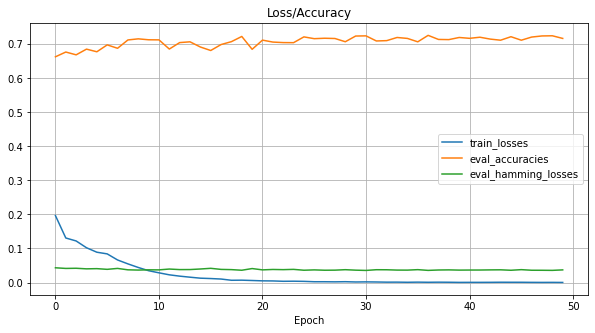

In [16]:
plt.figure(figsize=(10,5))
plt.title("Loss/Accuracy")
plt.plot(train_losses, label="train_losses")
plt.plot(eval_accuracies, label="eval_accuracies")
plt.plot(eval_hamming_losses, label="eval_hamming_losses")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()

# 10 Final Testing

In [17]:
def test_final_model():
    final_model = torch.load(FINAL_MODEL_PATH)
    final_model.eval()
    targets=[]
    predictions=[]

    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(DEVICE, dtype = torch.long)
            mask = data['mask'].to(DEVICE, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(DEVICE, dtype = torch.long)
            batch_targets = data['targets'].to(DEVICE, dtype = torch.float)
            batch_predictions = model(ids, mask, token_type_ids)
            targets.extend(batch_targets.cpu().detach().numpy().tolist())
            predictions.extend(torch.sigmoid(batch_predictions).cpu().detach().numpy().tolist())
    predictions = np.array(predictions) >= 0.5

    print('----------------------------------------------------------------------')
    print('MultiLabel Confusion Matrix:')
    print(multilabel_confusion_matrix(targets, predictions))
    print(f'[{datetime.now()}] Accuracy (Exact Match Ratio) Score={accuracy_score(targets, predictions)}')
    print(f'[{datetime.now()}] Hamming Loss={hamming_loss(targets, predictions)}')
    print(f'[{datetime.now()}] Classification Report:')
    print(classification_report(targets, predictions, digits=4, zero_division=0, target_names=mlb.classes_))
    print('----------------------------------------------------------------------')

print('Testing the final model (the best from training')
test_final_model()

Testing the final model (the best from training
----------------------------------------------------------------------
MultiLabel Confusion Matrix:
[[[3538   35]
  [  56  371]]

 [[3376   35]
  [  61  528]]

 [[3501   62]
  [  74  363]]

 [[3357   49]
  [ 137  457]]

 [[3319   79]
  [  87  515]]

 [[3610   16]
  [  23  351]]

 [[3554   35]
  [  63  348]]

 [[1898   65]
  [ 110 1927]]

 [[3074  101]
  [ 114  711]]

 [[2951  152]
  [ 127  770]]]
[2022-08-28 07:44:47.345013] Accuracy (Exact Match Ratio) Score=0.72475
[2022-08-28 07:44:47.355224] Hamming Loss=0.037025
[2022-08-28 07:44:47.365256] Classification Report:
                        precision    recall  f1-score   support

Database_Administrator     0.9138    0.8689    0.8908       427
   Front_End_Developer     0.9378    0.8964    0.9167       589
        Java_Developer     0.8541    0.8307    0.8422       437
 Network_Administrator     0.9032    0.7694    0.8309       594
       Project_manager     0.8670    0.8555    0.8612   